[View in Colaboratory](https://colab.research.google.com/github/keicoon/CapsNet/blob/master/tf-colab/CapsNet.ipynb)

In [0]:
# 필요한 모듈들을 불러옵니다
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [0]:
# HyperParameter를 여기서 설정합니다
batchSize = 128
epochNum = 500
data_dir = './mnist_data'

In [0]:
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.93

In [0]:
# # 구글 드라이브에서 MNIST 데이터 업로드
# from google.colab import files
# files.upload()

In [56]:
# 데이터를 batchSize에 맞게 잘라서 읽어옵니다
mnist = input_data.read_data_sets(data_dir, one_hot=True)
def getBatchData(isTrain = True):
  if isTrain:
    image, label = mnist.train.next_batch(batchSize, shuffle=True)
  else:
    image, label = mnist.validation.next_batch(batchSize, shuffle=True)
    
  return image, label

Extracting ./mnist_data/train-images-idx3-ubyte.gz
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/t10k-labels-idx1-ubyte.gz


In [0]:
# non-linear 활성화 함수
def squash(vector):
  normalVector = tf.reduce_sum(tf.square(vector), axis=-2, keep_dims=True)
  return vector * (normalVector / ((1 + normalVector) * tf.sqrt(normalVector + 1e-9)))

In [0]:
# conv 모양을 쌓을 수 있는 capsule layer를 만듭니다
def primaryCaps(input):
  # MNIST 실험에 맞게 설정한 세팅 값입니다
  outputChannel = 32
  vecLen = 8
  kernelSize = 9
  strides = 2
  # for문을 순회하며 capsule을 만드는 것보다 cov2d를 사용해서 reshpae로 모양을 뒤집는게 빠릅니다
  # shape=[conv2d_shape, output * vec]
  capsules = tf.contrib.layers.conv2d(input, outputChannel * vecLen, kernelSize, strides, padding='VALID')
  # 8개 property를 가지는 capsule 1152(6 * 6 * 32)개의 tensor를 얻습니다
  # shape=[cond2d_shape * output, vec]
  capsules = tf.reshape(capsules, (batchSize, -1, vecLen, 1))
  # 모든 capsule에 activation을 해줍니다
  capsules = squash(capsules)

  return capsules

In [0]:
# capsule layer간의 logit을 갱신해줍니다
def dynamicRouting(uji, bij):
  outputChannel = 10
  vecLen = 16
  # layer의 capsule property가 다른 경우 dimention을 맞춰주는 W(weight matrix)를 생성합니다
  # ex) 8 -> 16
  W = tf.get_variable('W', shape=(1, 1152, outputChannel, 8, vecLen),
                      dtype=tf.float32, 
                      initializer=tf.random_normal_initializer(stddev=0.01))
  # W의 모양에 맞게 matrix를 늘려 붙여줍니다
  uji = tf.tile(uji, [1, 1, outputChannel, 1, 1])
  # batchSize에 맞게 W도 늘려 붙여줍니다
  W = tf.tile(W, [batchSize, 1, 1, 1, 1])
  # capsule의 dimention을 맞춘 새로운 capsule입니다.
  # u^ji = W * uji
  uHatji = tf.matmul(W, uji, transpose_a=True)
  # routing 횟수를 정합니다. 논문에서는 3번이 적당하다고 합니다
  rNum = 3
  for r in range(rNum):
    # capsule이 전파되는 weight(coupling coefficient)의 총량은 1이 되어야 하므로 softmax 함수를 통해 weight를 normalize해줍니다
    cij = tf.nn.softmax(bij, dim=2)
    # weight를 casule에 반영해 줍니다
    # sj = E(cij * u^ji)
    sj = tf.multiply(cij, uHatji)
    sj = tf.reduce_sum(sj, axis=1, keep_dims=True)
    # *capsule들의 vector 값을 구합니다
    vj = squash(sj)
    # uHat의 shape에 맞춰 vj를 늘려 붙여줍니다
    vjTiled = tf.tile(vj, [1, 1152, 1, 1, 1])
    # a = uHat * vj
    a = tf.matmul(uHatji, vjTiled, transpose_a=True)
    # 계산된 agreement를 다음 routing에 반영하기 위해 bij에 더해줍니다. 마지막 iteration는 반영되지 않으므로 제외합니다
    if r < rNum - 1:
      bij += a

  return vj

In [0]:
# MNIST 예제에 맞게 마지막 network의 capsule 갯수를 10(0~9)개로 합니다
def digitCaps(input):
  outputChannel = 10
  # input으로 들어온 tensor를 한줄로 펴줍니다
  uji = tf.reshape(input, shape=(batchSize, -1, 1, 8, 1))
  # 두 capsule간의 weight를 의미하는 bij는 처음에 0값을 가집니다
  bij = tf.constant(np.zeros([batchSize, 1152, outputChannel, 1, 1], dtype=np.float32))
  # 두 layer의 capsule들을 연결을 갱신합니다
  capsules = dynamicRouting(uji, bij)
  # capsule의 불필요한 차원을 정리합니다
  capsules = tf.squeeze(capsules, axis=1)
  
  return capsules

In [0]:
def reconstruction(_label, caps2, vecLength):
  # 가장 길이가 큰 digit 캡슐를 선택함
  softmaxV = tf.nn.softmax(vecLength, dim=1)
  predictions = tf.to_int32(tf.argmax(softmaxV, axis=1))
  predictions = tf.reshape(predictions, shape=(batchSize,))
  # 정답 캡슐을 선택함
  maskedV = tf.matmul(tf.squeeze(caps2), tf.reshape(_label, (-1, 10, 1)), transpose_a=True)
  # capsule의 vector를 쭉 핌
  vJ = tf.reshape(maskedV, shape=(batchSize, -1))
  # dense를 쌓아올림
  fc1 = tf.contrib.layers.fully_connected(inputs=vJ, num_outputs=512)
  fc2 = tf.contrib.layers.fully_connected(inputs=fc1, num_outputs=1024)
  reconstruct = tf.contrib.layers.fully_connected(inputs=fc2, num_outputs=784, activation_fn=tf.sigmoid)
  
  return predictions, reconstruct

In [0]:
def capsNet(_image, _label):
  _image = tf.reshape(_image, shape=(batchSize, 28, 28, 1))
  # input으로 이미지를 받기 위해 간단한 conv2d를 첫번째 layer로 준비합니다
  conv1 = tf.contrib.layers.conv2d(_image, num_outputs=256, kernel_size=9, stride=1, padding='VALID')
  # caps layer를 쌓아 올립니다.
  caps1 = primaryCaps(conv1)
  caps2 = digitCaps(caps1)
  # 마지막 10개의 capsule의 vector에서 길이를 얻어 가장 높은 확률의 vector를 선택합니다
  vecLength = tf.sqrt(tf.reduce_sum(tf.square(caps2), axis=2, keep_dims=True) + 1e-9)
  # 복원에 필요한 레이어를 추가함
  predictions, reconstruct = reconstruction(_label, caps2, vecLength)

  return vecLength, predictions, reconstruct

In [0]:
def getLoss(vecLength, reconstruct, _image, _label):
  mPlus = 0.9
  mMinus = 0.1
  lambdaVal = 0.5
  reconLossWeight = 0.392
  # 아래 수식을 계산하여 loss 값을 반영합니다
  # Margin loss for digit existence
  # loss = Tk * max(0, m_plus - ||v_c||)^2 + lamb * (1 - Tk) * max(0, ||v_c|| - m_minus)^2
  Tk = _label
  
  maxL = tf.square(tf.maximum(0., mPlus - vecLength))
  maxL = tf.reshape(maxL, shape=(batchSize, -1))
  
  maxR = tf.square(tf.maximum(0., vecLength - mMinus))
  maxR = tf.reshape(maxR, shape=(batchSize, -1))

  Lk = Tk * maxL + lambdaVal * (1 - Tk) * maxR
  
  marginLoss = tf.reduce_mean(tf.reduce_mean(Lk, axis=1))
  imageTrue = tf.reshape(_image, shape=(batchSize, -1))
  # 원본과 재구성의 MSE
  reconLoss = tf.reduce_mean(tf.square(reconstruct - imageTrue))
  # reconstruction loss의 영향을 weight만큼 감소하게 함
  loss = marginLoss + reconLossWeight * reconLoss
  
  return loss

In [0]:
def getAccuracy(predictions, _label):
  label = tf.squeeze(tf.argmax(_label, axis=1, output_type=tf.int32))
  acc = tf.reduce_mean(tf.cast(tf.equal(label, predictions), dtype=tf.float32)) * 100
  
  return acc

[train] step: 1 loss: 0.172
[train] step: 2 loss: 0.171
[train] step: 3 loss: 0.171
[train] step: 4 loss: 0.171
[train] step: 5 loss: 0.171
[train] step: 6 loss: 0.171
[train] step: 7 loss: 0.170
[train] step: 8 loss: 0.169
[train] step: 9 loss: 0.168
[train] step: 10 loss: 0.167
[test] acc: 3.906


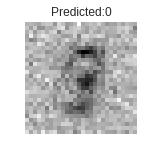

[train] step: 12 loss: 0.166
[train] step: 13 loss: 0.164
[train] step: 14 loss: 0.162
[train] step: 15 loss: 0.159
[train] step: 16 loss: 0.157
[train] step: 17 loss: 0.153
[train] step: 18 loss: 0.149
[train] step: 19 loss: 0.145
[train] step: 20 loss: 0.141
[test] acc: 11.719


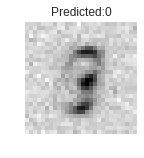

[train] step: 22 loss: 0.136
[train] step: 23 loss: 0.132
[train] step: 24 loss: 0.127
[train] step: 25 loss: 0.123
[train] step: 26 loss: 0.119
[train] step: 27 loss: 0.117
[train] step: 28 loss: 0.113
[train] step: 29 loss: 0.114
[train] step: 30 loss: 0.111
[test] acc: 8.594


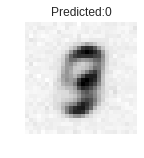

[train] step: 32 loss: 0.110
[train] step: 33 loss: 0.111
[train] step: 34 loss: 0.109
[train] step: 35 loss: 0.108
[train] step: 36 loss: 0.108
[train] step: 37 loss: 0.107
[train] step: 38 loss: 0.088
[train] step: 39 loss: 0.116
[train] step: 40 loss: 0.083
[test] acc: 12.500


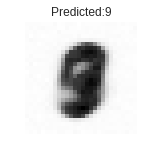

[train] step: 42 loss: 0.091
[train] step: 43 loss: 0.087
[train] step: 44 loss: 0.079
[train] step: 45 loss: 0.088
[train] step: 46 loss: 0.079
[train] step: 47 loss: 0.079
[train] step: 48 loss: 0.082
[train] step: 49 loss: 0.079
[train] step: 50 loss: 0.077
[test] acc: 32.812


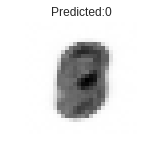

[train] step: 52 loss: 0.073
[train] step: 53 loss: 0.073
[train] step: 54 loss: 0.072
[train] step: 55 loss: 0.066
[train] step: 56 loss: 0.064
[train] step: 57 loss: 0.060
[train] step: 58 loss: 0.061
[train] step: 59 loss: 0.060
[train] step: 60 loss: 0.054
[test] acc: 72.656


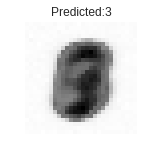

[train] step: 62 loss: 0.049
[train] step: 63 loss: 0.053
[train] step: 64 loss: 0.049
[train] step: 65 loss: 0.050
[train] step: 66 loss: 0.051
[train] step: 67 loss: 0.048
[train] step: 68 loss: 0.046
[train] step: 69 loss: 0.046
[train] step: 70 loss: 0.044
[test] acc: 77.344


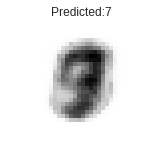

[train] step: 72 loss: 0.042
[train] step: 73 loss: 0.043
[train] step: 74 loss: 0.045
[train] step: 75 loss: 0.041
[train] step: 76 loss: 0.037
[train] step: 77 loss: 0.041
[train] step: 78 loss: 0.042
[train] step: 79 loss: 0.039
[train] step: 80 loss: 0.036
[test] acc: 86.719


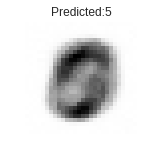

[train] step: 82 loss: 0.038
[train] step: 83 loss: 0.038
[train] step: 84 loss: 0.035
[train] step: 85 loss: 0.037
[train] step: 86 loss: 0.039
[train] step: 87 loss: 0.037
[train] step: 88 loss: 0.033
[train] step: 89 loss: 0.034
[train] step: 90 loss: 0.034
[test] acc: 90.625


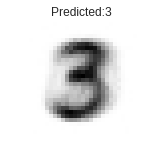

[train] step: 92 loss: 0.034
[train] step: 93 loss: 0.035
[train] step: 94 loss: 0.034
[train] step: 95 loss: 0.033
[train] step: 96 loss: 0.032
[train] step: 97 loss: 0.031
[train] step: 98 loss: 0.031
[train] step: 99 loss: 0.030
[train] step: 100 loss: 0.032
[test] acc: 93.750


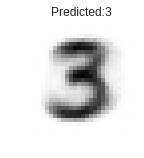

[train] step: 102 loss: 0.032
[train] step: 103 loss: 0.034
[train] step: 104 loss: 0.032
[train] step: 105 loss: 0.028
[train] step: 106 loss: 0.029
[train] step: 107 loss: 0.030
[train] step: 108 loss: 0.030
[train] step: 109 loss: 0.032
[train] step: 110 loss: 0.030
[test] acc: 94.531


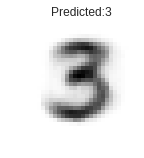

[train] step: 112 loss: 0.030
[train] step: 113 loss: 0.029
[train] step: 114 loss: 0.029
[train] step: 115 loss: 0.030
[train] step: 116 loss: 0.027
[train] step: 117 loss: 0.027
[train] step: 118 loss: 0.028
[train] step: 119 loss: 0.028
[train] step: 120 loss: 0.028
[test] acc: 95.312


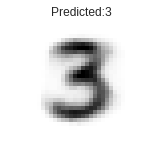

[train] step: 122 loss: 0.027
[train] step: 123 loss: 0.028
[train] step: 124 loss: 0.030
[train] step: 125 loss: 0.028
[train] step: 126 loss: 0.027
[train] step: 127 loss: 0.027
[train] step: 128 loss: 0.026
[train] step: 129 loss: 0.028
[train] step: 130 loss: 0.027
[test] acc: 93.750


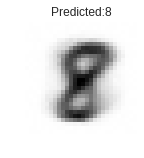

[train] step: 132 loss: 0.027
[train] step: 133 loss: 0.025
[train] step: 134 loss: 0.025
[train] step: 135 loss: 0.025
[train] step: 136 loss: 0.026
[train] step: 137 loss: 0.027
[train] step: 138 loss: 0.026
[train] step: 139 loss: 0.026
[train] step: 140 loss: 0.028
[test] acc: 95.312


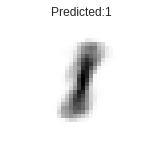

[train] step: 142 loss: 0.024
[train] step: 143 loss: 0.027
[train] step: 144 loss: 0.023
[train] step: 145 loss: 0.026
[train] step: 146 loss: 0.024
[train] step: 147 loss: 0.025
[train] step: 148 loss: 0.025
[train] step: 149 loss: 0.024
[train] step: 150 loss: 0.026
[test] acc: 97.656


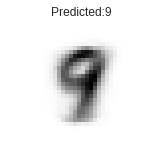

[train] step: 152 loss: 0.025
[train] step: 153 loss: 0.026
[train] step: 154 loss: 0.023
[train] step: 155 loss: 0.025


In [0]:
def train():
  
  tf.reset_default_graph()
    
  with tf.Session(config=config) as sess:
    
    _image = tf.placeholder(tf.float32, [batchSize, 784])
    _label = tf.placeholder(tf.float32, [batchSize, 10])
    
    vecLength, predictions, reconstruct = capsNet(_image, _label)
    # shape만 변경함
    predImage = tf.reshape(reconstruct, shape=(-1, 28, 28, 1))
    
    totalLoss = getLoss(vecLength, reconstruct, _image, _label)
    totalAcc = getAccuracy(predictions, _label)
    
    global_step = tf.Variable(0, name='global_step', trainable=False)
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(totalLoss, global_step=global_step)

    sess.run(tf.global_variables_initializer())
    for e in range(epochNum):
      global_step_num = sess.run(global_step)
      
      if e % 10 == 0 and e > 0: # test
        testImage, testLabel = getBatchData(False)
        acc = sess.run(totalAcc,
                           feed_dict={_image: testImage, _label: testLabel})
        print('[test] acc: {:>3.3f}'.format(acc))
        reconImgs, pred = sess.run([predImage, predictions],
                           feed_dict={_image: testImage, _label: testLabel})
        predImgs = reconImgs.reshape([-1, 28, 28])
        # 그림을 그림
        plt.figure(figsize=(2, 3))
        plt.subplot(1, 1, 1)
        plt.title("Predicted:" + str(pred[0]))
        plt.imshow(predImgs[0], cmap="binary")
        plt.axis("off")
        plt.show()
      else: # train
        image, label = getBatchData()
        
        _, loss = sess.run([train_op, totalLoss],
                           feed_dict={_image: image, _label: label})
        print('[train] step: {} loss: {:>3.3f}'.format(e + 1, loss))

train()